# 访客数转化 -百丽官方旗舰店

In [1]:
import pandas as pd 
import numpy as np
from scipy.optimize import curve_fit  
import matplotlib.pyplot as plt 
import datetime
# from sklearn import cross_validation
from impala.dbapi import connect
from impala.util import as_pandas
import json
import pymysql
from sqlalchemy import create_engine
import os

In [2]:
#### 京东指数取数
# 连接集群hive/impala
def impala_connect(sql, **kwargs):
# impala 
    host = kwargs.get("host", 'impala.bjds.belle.lan')
    port = kwargs.get("port", 21051)    
    timeout = kwargs.get("timeout", 3600)
# hive
    # host = kwargs.get("host", 'impala.bjds.belle.lan')
    # port = kwargs.get("port", 10008)    
    # timeout = kwargs.get("timeout", 3600)
    user = kwargs.get("user", "lv.d.sz")
    password = kwargs.get("password", 'JHjLXpyQ')
    kerberos_service_name = kwargs.get("kerberos_service_name", "impala")
    conn = connect(host=host, port=port, timeout=timeout, user=user, password=password, kerberos_service_name=
                   kerberos_service_name,auth_mechanism='LDAP')
    cur = conn.cursor(user=user)
    if sql is not None:
        cur.execute(sql)
        try:
            df = as_pandas(cur)
        except:
            return cur
    return df


In [17]:
##mysql
# mysql 数据库连接
class MySQLConn(object):
    """Class supply connection to mysql database"""
    def __init__(self, **info):
        self.host = info.get("host", "10.251.11.15")
        self.user = info.get("user", "sz_analy")
        self.port = info.get("port", 3306)
        self.password = info.get("password", "Belle2020@sz")
        self.db = info.get("db", "bi_analysis_sz")
        self.table = info.get("table", "jd_sz_item_analysis_temp")
        # self.table_add = info.get("table_add", None)
        self.charset = info.get("charset", "utf8mb4")
        try:
            self.conn = pymysql.connect(host=self.host, port=self.port,
                                    user=self.user, password=self.password, db=self.db, charset=self.charset)
            self.cur = self.conn.cursor()
        except pymysql.err.OperationalError as e:
            print('Error is ' + str(e))
            sys.exit()

    def read_mysql(self, col=None, where_append=None, chunk_size=500000):
        if col is None:
            col = "*"
        if where_append is None:
            where_append = ''
        try:
            sql = 'select %s from %s %s' % (col, self.table, where_append)
            dfs = pd.read_sql(sql, con=self.conn, chunksize=chunk_size)
        except pymysql.err.ProgrammingError as e:
            print('Error is ' + str(e))
            sys.exit()
        dfs = list(dfs)
        if len(list(dfs)) == 0:
            return None
        else:
            return pd.concat(dfs)
    def read_mysql2(self, sql, col=None, where_append=None, chunk_size=500000):
        """读取写的sql代码"""
        try:
            dfs = pd.read_sql(sql, con=self.conn, chunksize=chunk_size)
            dfs = list(dfs)
            if len(list(dfs)) == 0:
                return None
            else:
                return pd.concat(dfs)
        except pymysql.err.ProgrammingError as e:
            print('Error is ' + str(e))
            sys.exit()


    def to_sql(self, df, apply_date, *args):
        pass

    def close(self):
        self.conn.close()

In [20]:
sql2 = """
select 
       belle_shop_name as 店铺,
       category as 一级类目,
       ifnull(child_category, category) as 二级类目,
       date_type as `日期`,
       visitor_number as 访客人数,
       deal_num as 成交金额
from jd_sz_item_analysis_temp
"""

In [21]:
mysql1 = MySQLConn()
df = mysql1.read_mysql2(sql= sql2)

In [22]:
df.head()

,店铺,一级类目,二级类目,日期,访客人数,成交金额
0,SKAP旗舰店,流行男鞋,商务休闲鞋,2020-05-04,772,14320.8
1,天美意官方旗舰店,潮流女包,单肩包,2019-11-06,96,0.0
2,百丽官方旗舰店,流行男鞋,商务休闲鞋,2019-04-19,260,0.0
3,暇步士官方旗舰店,流行男鞋,凉鞋/沙滩鞋,2020-03-26,269,902.0
4,他她官方旗舰店,精品男包,精品男包,2019-01-23,0,0.0


### 读取excel 一级类目、二级类目访客数、gmv真实值

In [3]:
df_jd= pd.read_excel('jd_sz_item_analysis.xlsx', sheet_name = 'jd_sz_item_analysis')
df_belle = df_jd.loc[df_jd['belle_shop_name']=='百丽官方旗舰店',]
df_belle = df_belle[['belle_shop_name','date_type','一级类目','二级类目','访客数','成交金额']]
df_belle.head()

,belle_shop_name,date_type,一级类目,二级类目,访客数,成交金额
2,百丽官方旗舰店,2020-05-23,流行男鞋,流行男鞋,6125,83339.05
6,百丽官方旗舰店,2020-05-23,潮流女包,单肩包,741,2658.10
7,百丽官方旗舰店,2020-05-23,流行男鞋,凉鞋/沙滩鞋,486,9191.40
8,百丽官方旗舰店,2020-05-23,流行男鞋,男靴,390,1292.60
9,百丽官方旗舰店,2020-05-23,时尚女鞋,高跟鞋,2156,14589.25


In [23]:
## 读取集群里的指数
sql1 ="""
-- 一级品类店铺top100日度数据
select
start_day as `日期`, 
category as `一级类目`,
CASE  child_category WHEN  "" THEN category
else child_category end as `二级类目`, 
shop_name `店铺`,
gmv_amount_index as `成交金额指数`,
visitor_index as `访客指数`
from  bi_analysis.jd_sz_vender_ranks 
where 1=1
-- and category in ('时尚女鞋','流行男鞋','潮流女包') 
--and child_category = ""
and start_day >= '2019-01-01'
and end_day <='2020-05-23'
and length(date_type) = 10
and belle_shop_name = '百丽官方旗舰店'
and shop_name in  ('百丽官方旗舰店','他她官方旗舰店','天美意官方旗舰店','暇步士官方旗舰店')
order by start_day, category
"""

In [24]:
df1 = impala_connect(sql1)
df1.head()

,日期,一级类目,二级类目,店铺,成交金额指数,访客指数
0,2019-01-01,时尚女鞋,休闲鞋,天美意官方旗舰店,1550227.0,92921.0
1,2019-01-01,时尚女鞋,单鞋,天美意官方旗舰店,1881493.0,50586.0
2,2019-01-01,时尚女鞋,女靴,他她官方旗舰店,6434530.0,403933.0
3,2019-01-01,时尚女鞋,鱼嘴鞋,他她官方旗舰店,0.0,674.0
4,2019-01-01,时尚女鞋,踝靴,百丽官方旗舰店,4288128.0,168944.0


In [25]:
df_belle.rename(columns = {'date_type':'日期','子类目':'二级类目'},inplace = True)
df1.rename(columns = {'date_type':'日期','子类目':'二级类目'},inplace = True)

NameError: name 'df_belle' is not defined

In [26]:
df2 = df1.merge(df, on =['日期','店铺','一级类目','二级类目'],how = 'left')

In [27]:
df2 

,日期,一级类目,二级类目,店铺,成交金额指数,访客指数,访客人数,成交金额
0,2019-01-01,时尚女鞋,休闲鞋,天美意官方旗舰店,1550227.0,92921.0,1777.0,0.00
1,2019-01-01,时尚女鞋,单鞋,天美意官方旗舰店,1881493.0,50586.0,959.0,0.00
2,2019-01-01,时尚女鞋,女靴,他她官方旗舰店,6434530.0,403933.0,8167.0,0.00
3,2019-01-01,时尚女鞋,鱼嘴鞋,他她官方旗舰店,0.0,674.0,20.0,0.00
4,2019-01-01,时尚女鞋,踝靴,百丽官方旗舰店,4288128.0,168944.0,3259.0,0.00
...,...,...,...,...,...,...,...,...
16451,2020-05-23,潮流女包,斜挎包,天美意官方旗舰店,305800.0,15736.0,306.0,1451.20
16452,2020-05-23,潮流女包,双肩包,天美意官方旗舰店,228602.0,5501.0,116.0,1004.20
16453,2020-05-23,潮流女包,手提包,百丽官方旗舰店,436972.0,18429.0,355.0,2266.00
16454,2020-05-23,潮流女包,单肩包,百丽官方旗舰店,494040.0,38966.0,741.0,2658.10


In [125]:
# df2.to_excel('访客数_拟合值.xlsx',sheet_name ='访客数拟合')

In [28]:
df_visit = df2[["一级类目","二级类目","店铺","访客指数","访客人数"]]

In [29]:
len(df_visit)

16456

In [30]:
df_visit.head()

,一级类目,二级类目,店铺,访客指数,访客人数
0,时尚女鞋,休闲鞋,天美意官方旗舰店,92921.0,1777.0
1,时尚女鞋,单鞋,天美意官方旗舰店,50586.0,959.0
2,时尚女鞋,女靴,他她官方旗舰店,403933.0,8167.0
3,时尚女鞋,鱼嘴鞋,他她官方旗舰店,674.0,20.0
4,时尚女鞋,踝靴,百丽官方旗舰店,168944.0,3259.0


In [33]:
### 测试
def visit_data(df_visit, category1, category2):
    """筛选出品类的数据"""
    df_wom = df_visit.loc[(df_visit['一级类目'].isin(category1))& (df_visit['二级类目'].isin(category2)),]
    df_all1 = df_wom[['访客指数',"访客人数"]]
    print("改品类下数据共有%d"%len(df_wom))
    return df_all1

In [214]:
df_all1 = visit_data(df_visit = df_visit , category1 = ['时尚女鞋','流行男鞋','潮流女包'], category2 = ['时尚女鞋','流行男鞋','潮流女包'])
df_all1.drop_duplicates(inplace = True) # 删除重复值
df_all1.dropna( inplace = True) # 删除空值
df_all1.sort_values(by = '访客指数' ,inplace =True)
df_all1.drop_duplicates(subset = ['访客指数'], inplace = True)

改品类下数据共有2560


In [202]:
df_all1 

,访客指数,访客人数
1036,10086.0,201.0
1044,11967.0,218.0
11947,12774.0,252.0
12225,16490.0,320.0
12265,17136.0,333.0
...,...,...
5722,14919182.0,433604.0
3460,15748794.0,461985.0
15729,15766439.0,462543.0
10743,17873292.0,534318.0


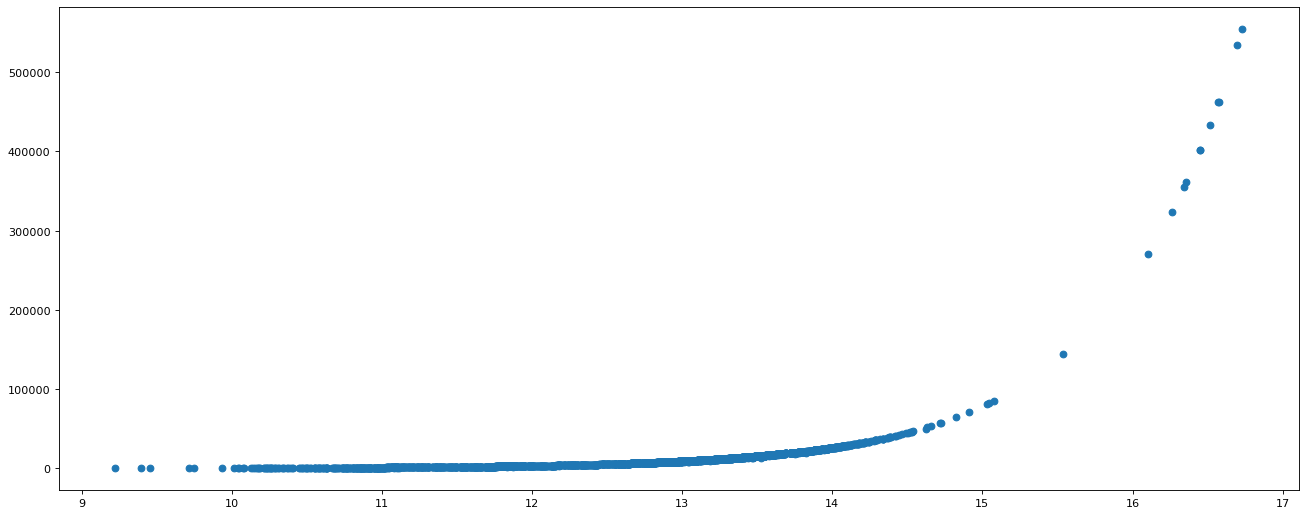

In [80]:
_x = np.log(df_all1['访客指数'])
# _x = df_all1['访客指数']
_y = df_all1['访客人数']
plt.figure('所有点', figsize= (20,8), dpi =80)
plt.scatter(_x, _y)
plt.show() # 整体趋势呈现某个指数形式增长

In [81]:
pd.concat([_x,_y],axis =1)

,访客指数,访客人数
1036,9.218904,201.0
1044,9.389908,218.0
11947,9.455167,252.0
12225,9.710509,320.0
12265,9.748937,333.0
...,...,...
5722,16.518158,433604.0
3460,16.572274,461985.0
15729,16.573394,462543.0
10743,16.698818,534318.0


In [203]:
## 异常值修正： 根据访客指数、访客人数排序进行修正，依据相邻指数的大小关系进行一个大小调整修正
def adj(df1):
    """大小顺序调整"""
    df_check = rank_all(df1)
    for i in range(len(df_check)-1):
        if df_check['rank0'][i] !=df_check['rank1'][i]:
            z= (np.log(df_check.loc[i+1,'指数'])-np.log(df_check.loc[i,'指数']))/(np.log(df_check.loc[i+1,'指数'])-np.log(df_check.loc[i-1,'指数']))                                                                                   
            df_check.loc[i,'值']=   df_check.loc[i+1,'值']-z*(df_check.loc[i+1,'值']-df_check.loc[i-1,'值'])
            df_check['rank1'] = df_check['值'].rank(method = 'first', ascending = True)
    return df_check

In [204]:
## 分别对指数和实际值进行排序
def rank_all(df):
    df.rename(columns = {'访客指数':'指数','访客人数':'值'}, inplace  = True)
    df['rank0'] = df['指数'].rank(method = 'first', ascending = True)
    df['rank1'] = df['值'].rank(method = 'first', ascending = True)
    df.reset_index(drop =True, inplace =True)
    return df

In [205]:
df_adj = adj(df_all1)
# df_adj.to_csv('调整后的指数.csv',encoding = 'gbk', index = None)


In [206]:
df_adj.rename(columns = {'指数':'访客指数','值':'访客人数'}, inplace  = True)
df_adj.drop(['rank0','rank1'],axis =1,inplace =True)

In [207]:
# 拟合
def fund(x, a, b):  
    """gmv = a*exp(ln指数*b)"""
    return a * np.exp(b * x)
def cur_fitted(i,j,data1):
    """gmv = a*exp(ln指数*b)"""
    _x = data1['访客指数']
    _y = data1['访客人数']
    _x1 = _x[i:j]
#     _y1 = np.log(_x1)
    xdata= np.log(_x1)
    ydata =_y[i:j]
    plt.scatter(xdata,ydata)  
    popt, pcov = curve_fit(fund, xdata, ydata,maxfev=500000) 
    y2 = [fund(i, popt[0],popt[1]) for i in xdata]  
    plt.plot(xdata,y2,'r--')
    error_c = (y2- ydata)/ydata*100
    cur_result = pd.DataFrame([list(_x1),list(ydata),y2,list(error_c)]).T
    cur_result.columns = ['指数','实际值','拟合值','误差率（%）']
    return popt,cur_result

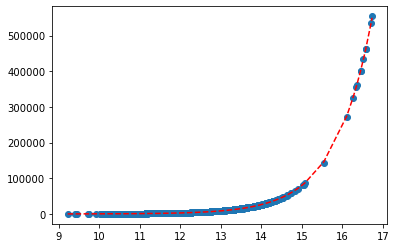

In [208]:
popt, result = cur_fitted(0,len(df_adj),df_adj)

###  低指数范围

In [249]:
df_dd1  = pd.read_excel('belle店铺指数低范围.xlsx',sheet_name = 'Sheet1')

In [250]:
list1 = [0,10,30,50,70,90,120,140,180,len(df_dd1)]
len(list1)

10

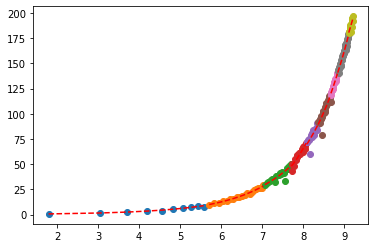

In [253]:
list2 = list()
df_result = pd.DataFrame()
df_c1 = pd.DataFrame()
data1 = df_dd1  #df_adj #
for i in range(len(list1)-1):
    popt, result = cur_fitted(list1[i],list1[i+1],data1)
    df_result = pd.concat([df_result,result])
    df_c1 = pd.concat([df_c1,pd.DataFrame(popt).T])

In [254]:
 df_c1.head()

,0,1
0,0.208101,0.673264
0,0.109456,0.790822
0,0.132763,0.765578
0,0.011346,1.082601
0,0.045366,0.907121


In [257]:
 df_result

,指数,实际值,拟合值,误差率（%）
0,6.0,1.000000,0.695304,-30.469584
1,21.0,1.500000,1.616130,7.741986
2,41.0,2.500000,2.535729,1.429172
3,67.0,3.500000,3.529425,0.840723
4,95.0,3.666667,4.464817,21.767738
...,...,...,...,...
14,9818.0,186.250000,191.501273,2.819475
15,9872.0,192.600000,192.279761,-0.166272
16,9925.0,195.000000,193.042756,-1.003715
17,9979.0,191.857143,193.819056,1.022591


In [258]:
writer = pd.ExcelWriter('belle店铺低指数范围.xlsx')
df_result.to_excel(writer,encoding= 'gbk', sheet_name='拟合值及误差',index =None)
df_c1.to_excel(writer,encoding= 'gbk', sheet_name='分段函数系数')
writer.close()

## 高指数范围

In [233]:
list1 = [0,10,30,60,100,200,360,400,417,450,500,800,1200,1300,1340,1378,1420,1500,2000,2200,2300,2350,2365,len(df_all1)]
len(list1)

24

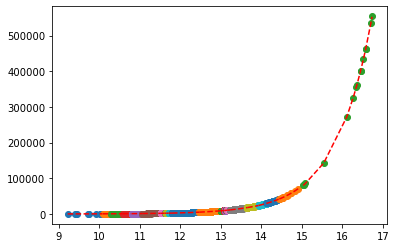

In [234]:
list2 = list()
df_result = pd.DataFrame()
df_c = pd.DataFrame()
data1 = df_all1  #df_adj #
for i in range(len(list1)-1):
    popt, result = cur_fitted(list1[i],list1[i+1],data1)
    df_result = pd.concat([df_result,result])
    df_c = pd.concat([df_c,pd.DataFrame(popt).T])

In [235]:
df_c.columns =['a','b']
list1.pop()
z = data1.iloc[list1,]['访客指数']
df_c.index = z 

In [236]:
df_result.head(10)

,指数,实际值,拟合值,误差率（%）
0,10086.0,201.0,195.927545,-2.523609
1,11967.0,218.0,231.393624,6.143864
2,12774.0,252.0,246.561794,-2.158018
3,16490.0,320.0,316.094952,-1.220327
4,17136.0,333.0,328.136531,-1.460501
5,20527.0,379.0,391.154056,3.206875
6,22248.0,428.0,423.025740,-1.162210
7,22946.0,436.0,435.932880,-0.015394
8,23107.0,441.0,438.908508,-0.474261
9,23751.0,450.0,450.805449,0.178989


In [237]:
df_c

,a,b
访客指数,,
10086.0,0.024932,0.972929
23913.0,0.012604,1.038749
29324.0,0.014870,1.023011
39285.0,0.028808,0.960334
48902.0,0.023604,0.978967
63610.0,0.008650,1.068719
100654.0,0.013742,1.027231
110562.0,0.015483,1.016658
114756.0,0.022771,0.983577


In [238]:
len(df_c)

23

In [213]:
writer = pd.ExcelWriter('belle店铺访客指数拟合结果2.xlsx')
df_result.to_excel(writer,encoding= 'gbk', sheet_name='拟合值及误差',index =None)
df_c.to_excel(writer,encoding= 'gbk', sheet_name='分段函数系数')
writer.close()

#### 访客指数转化api

In [262]:
df_c1 = pd.read_excel('belle店铺访客指数分段系数.xlsx',sheet_name = 'Sheet1')
df_c1.index= df_c1['访客指数']

In [266]:
len(df_c1)

32

In [263]:
#### 计算函数：
def fund(x, a, b):  
    """gmv = a*exp(ln指数*b)"""
    return a * np.exp(b * x)

In [267]:
def fun_fit1(x):
    global df_c1
    df_c = df_c1
    list3 = df_c.index
    if list3[0]<=x<list3[1]:
        a = df_c.loc[list3[0],'a']
        b = df_c.loc[list3[0],'b']
    elif list3[1]<=x<list3[2]:
        a = df_c.loc[list3[1],'a']
        b = df_c.loc[list3[1],'b']  
    elif list3[2]<=x<list3[3]:
        a = df_c.loc[list3[2],'a']
        b = df_c.loc[list3[2],'b']  
    elif list3[3]<=x<list3[4]:
        a = df_c.loc[list3[3],'a']
        b = df_c.loc[list3[3],'b']
    elif list3[4]<=x<list3[5]:
        a = df_c.loc[list3[4],'a']
        b = df_c.loc[list3[4],'b']
    elif list3[5]<=x<list3[6]:
        a = df_c.loc[list3[5],'a']
        b = df_c.loc[list3[5],'b']  
    elif list3[6]<=x<list3[7]:
        a = df_c.loc[list3[6],'a']
        b = df_c.loc[list3[6],'b']  
    elif list3[7]<=x<list3[8]:
        a = df_c.loc[list3[7],'a']
        b = df_c.loc[list3[7],'b']
    elif list3[8]<=x<list3[9]:
        a = df_c.loc[list3[8],'a']
        b = df_c.loc[list3[8],'b']  
    elif list3[9]<=x<list3[10]:
        a = df_c.loc[list3[9],'a']
        b = df_c.loc[list3[9],'b']  
    elif list3[10]<=x<list3[11]:
        a = df_c.loc[list3[10],'a']
        b = df_c.loc[list3[10],'b']
    elif list3[11]<=x<list3[12]:
        a = df_c.loc[list3[11],'a']
        b = df_c.loc[list3[11],'b']
    elif list3[12]<=x<list3[13]:
        a = df_c.loc[list3[12],'a']
        b = df_c.loc[list3[12],'b']  
    elif list3[13]<=x<list3[14]:
        a = df_c.loc[list3[13],'a']
        b = df_c.loc[list3[13],'b']  
    elif list3[14]<=x<list3[15]:
        a = df_c.loc[list3[14],'a']
        b = df_c.loc[list3[14],'b']
    elif list3[15]<=x<list3[16]:
        a = df_c.loc[list3[15],'a']
        b = df_c.loc[list3[15],'b']  
    elif list3[16]<=x<list3[17]:
        a = df_c.loc[list3[16],'a']
        b = df_c.loc[list3[16],'b']  
    elif list3[17]<=x<list3[18]:
        a = df_c.loc[list3[17],'a']
        b = df_c.loc[list3[17],'b']
    elif list3[18]<=x<list3[19]:
        a = df_c.loc[list3[18],'a']
        b = df_c.loc[list3[18],'b']
    elif list3[19]<=x<list3[20]:
        a = df_c.loc[list3[19],'a']
        b = df_c.loc[list3[19],'b']
    elif list3[20]<=x<list3[21]:
        a = df_c.loc[list3[20],'a']
        b = df_c.loc[list3[20],'b']
    elif list3[21]<=x<list3[22]:
        a = df_c.loc[list3[21],'a']
        b = df_c.loc[list3[21],'b']
    elif list3[22]<=x<list3[23]:
        a = df_c.loc[list3[22],'a']
        b = df_c.loc[list3[22],'b']
    elif list3[23]<=x<list3[24]:
        a = df_c.loc[list3[23],'a']
        b = df_c.loc[list3[23],'b']  
    elif list3[24]<=x<list3[25]:
        a = df_c.loc[list3[24],'a']
        b = df_c.loc[list3[24],'b']  
    elif list3[25]<=x<list3[26]:
        a = df_c.loc[list3[25],'a']
        b = df_c.loc[list3[25],'b']
    elif list3[26]<=x<list3[27]:
        a = df_c.loc[list3[26],'a']
        b = df_c.loc[list3[26],'b']
    elif list3[27]<=x<list3[28]:
        a = df_c.loc[list3[27],'a']
        b = df_c.loc[list3[27],'b']
    elif list3[28]<=x<list3[29]:
        a = df_c.loc[list3[28],'a']
        b = df_c.loc[list3[28],'b']
    elif list3[29]<=x<list3[30]:
        a = df_c.loc[list3[29],'a']
        b = df_c.loc[list3[29],'b']
    elif list3[30]<=x<list3[31]:
        a = df_c.loc[list3[30],'a']
        b = df_c.loc[list3[30],'b']
    else:
        a = df_c.loc[list3[31],'a']
        b = df_c.loc[list3[31],'b']
    y = fund(np.log(x),a,b)
    print(a,b)
    return y

In [272]:
fun_fit(10033)

0.2135569179550535 0.7396395259244631


194.59426353145196

In [278]:
fun_fit(14919182)

0.003086111901959644 1.135866647636572


434339.5401505949